In [1]:
# Importing packages
import pandas as pd
import numpy as np
import seaborn as sns
import missingno as msno
import matplotlib.pyplot as plt
from fuzzywuzzy import process
from fuzzywuzzy import fuzz
import pycountry
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.impute import KNNImputer
from sklearn.metrics import mean_squared_error
import zipfile

In [2]:
# Importing data
main_df = pd.read_excel("Data/organizedviolencecy_v23_2.xlsx")

# List of country codes to keep (recognized country)
recognized_country_codes = [
    "AFG", "ALA", "ALB", "DZA", "ASM", "AND", "AGO", "AIA", "ATA", "ATG", "ARG", "ARM", "ABW", "AUS", "AUT", "AZE",
    "BHS", "BHR", "BGD", "BRB", "BLR", "BEL", "BLZ", "BEN", "BMU", "BTN", "BOL", "BES", "BIH", "BWA", "BVT", "BRA",
    "IOT", "BRN", "BGR", "BFA", "BDI", "CPV", "KHM", "CMR", "CAN", "CYM", "CAF", "TCD", "CHL", "CHN", "CXR", "CCK",
    "COL", "COM", "COG", "COD", "COK", "CRI", "CIV", "HRV", "CUB", "CUW", "CYP", "CZE", "DNK", "DJI", "DMA", "DOM",
    "ECU", "EGY", "SLV", "GNQ", "ERI", "EST", "SWZ", "ETH", "FLK", "FRO", "FJI", "FIN", "FRA", "GUF", "PYF", "ATF",
    "GAB", "GMB", "GEO", "DEU", "GHA", "GIB", "GRC", "GRL", "GRD", "GLP", "GUM", "GTM", "GGY", "GIN", "GNB", "GUY",
    "HTI", "HMD", "VAT", "HND", "HKG", "HUN", "ISL", "IND", "IDN", "IRN", "IRQ", "IRL", "IMN", "ISR", "ITA", "JAM",
    "JPN", "JEY", "JOR", "KAZ", "KEN", "KIR", "PRK", "KOR", "KWT", "KGZ", "LAO", "LVA", "LBN", "LSO", "LBR", "LBY",
    "LIE", "LTU", "LUX", "MAC", "MDG", "MWI", "MYS", "MDV", "MLI", "MLT", "MHL", "MTQ", "MRT", "MUS", "MYT", "MEX",
    "FSM", "MDA", "MCO", "MNG", "MNE", "MSR", "MAR", "MOZ", "MMR", "NAM", "NRU", "NPL", "NLD", "NCL", "NZL", "NIC",
    "NER", "NGA", "NIU", "NFK", "MKD", "MNP", "NOR", "OMN", "PAK", "PLW", "PSE", "PAN", "PNG", "PRY", "PER", "PHL",
    "PCN", "POL", "PRT", "PRI", "QAT", "REU", "ROU", "RUS", "RWA", "BLM", "SHN", "KNA", "LCA", "MAF", "SPM", "VCT",
    "WSM", "SMR", "STP", "SAU", "SEN", "SRB", "SYC", "SLE", "SGP", "SXM", "SVK", "SVN", "SLB", "SOM", "ZAF", "SGS",
    "SSD", "ESP", "LKA", "SDN", "SUR", "SJM", "SWE", "CHE", "SYR", "TWN", "TJK", "TZA", "THA", "TLS", "TGO", "TKL",
    "TON", "TTO", "TUN", "TUR", "TKM", "TCA", "TUV", "UGA", "UKR", "ARE", "GBR", "USA", "UMI", "URY", "UZB", "VUT",
    "VEN", "VNM", "VGB", "VIR", "WLF", "ESH", "YEM", "ZMB", "ZWE"
]


In [3]:


# Create dictionaries to map country names to ISO codes and vice versa
country_name_to_iso = {country.name: country.alpha_3 for country in pycountry.countries}
iso_to_country_name = {country.alpha_3: country.name for country in pycountry.countries}

# Create DataFrames from the dictionaries
df_country_name_to_iso = pd.DataFrame(list(country_name_to_iso.items()), columns=['Country Name', 'ISO_Code'])
df_iso_to_country_name = pd.DataFrame(list(iso_to_country_name.items()), columns=['ISO_Code', 'Country Name'])

# Merge the DataFrames into a single DataFrame without duplicating "Country Name"
iso_df = pd.merge(df_country_name_to_iso, df_iso_to_country_name, on='ISO_Code', how='inner', suffixes=('_country', '_iso'))

# Rename the "Country Name" column to "Name"
iso_df.rename(columns={'Country Name_country': 'Name', 'ISO_Code': 'stateid'}, inplace=True)

# Drop the duplicate "Country Name_iso" column
iso_df.drop(columns=['Country Name_iso'], inplace=True)

# Only keep the countries in the recognized_country_codes list
iso_df = iso_df[iso_df['stateid'].isin(recognized_country_codes)]



In [4]:
# Cleaning of GDP dataset: GDP between 1989 and 2022 in current US dollars
gdp_df = pd.read_csv("Data/gdp_world.csv", skiprows=4)

# Only keep Country Code is in recognized_country_codes
gdp_df = gdp_df[gdp_df["Country Code"].isin(recognized_country_codes)]

# Only keep relevant columns
gdp_df = gdp_df[["Country Name", "Country Code", "1989", "1990", "1991", "1992", "1993", "1994", "1995", "1996", "1997",
                 "1998", "1999", "2000", "2001", "2002", "2003", "2004", "2005", "2006", "2007", "2008", "2009", "2010",
                 "2011", "2012", "2013", "2014", "2015", "2016", "2017", "2018", "2019", "2020", "2021", "2022"]]

# Only keep the countries recognized in the recognized_country_codes list
gdp_df = gdp_df[gdp_df["Country Code"].isin(recognized_country_codes)]

# Backfill NaN values
gdp_df = gdp_df.fillna(method='bfill', axis=1)

# rename Country Code to stateid
gdp_df = gdp_df.rename(columns={"Country Code": "stateid"})

# Frontfill NaN values -> some countries miss their 2022 value
gdp_df = gdp_df.fillna(method='ffill', axis=1)


# Initialize the mapping dictionary
name_mapping = {
    "Congo, Dem. Rep.": "Congo",
    "Tanzania": "Tanzania, United Republic of",
    "Turkiye": "Türkiye",
    "Moldova": "Moldova, Republic of",
    "Bahamas, The": "Bahamas",
    "Macao SAR, China": "China",
    "Korea, Rep.": "Korea, Republic of",
    "Curacao": "Curaçao",
    "Egypt, Arab Rep.": "Egypt",
    "Congo, Rep.": "Congo",
    "Bolivia": "Bolivia, Plurinational State of",
    "Virgin Islands (U.S.)": "Virgin Islands, U.S.",
    "St. Vincent and the Grenadines": "Saint Vincent and the Grenadines",
    "St. Martin (French part)": "Saint Martin (French part)",
    "Hong Kong SAR, China": "Hong Kong",
    "British Virgin Islands": "Virgin Islands, British",
    "Yemen, Rep.": "Yemen",
    "Cote d'Ivoire": "Côte d'Ivoire",
    "St. Kitts and Nevis": "Saint Kitts and Nevis",
    "Gambia, The": "Gambia",
    # Add mappings for the countries not found in the ISO dataset
    "Micronesia, Fed. Sts.": "",  # Change this to the correct ISO name
    "Lao PDR": "",  # Change this to the correct ISO name
    "Iran, Islamic Rep.": "",  # Change this to the correct ISO name
    "Korea, Dem. People's Rep.": "",  # Change this to the correct ISO name
    "Kyrgyz Republic": "",  # Change this to the correct ISO name
    "St. Lucia": "",  # Change this to the correct ISO name
    "Slovak Republic": "",  # Change this to the correct ISO name
}

# Manually update the mapping dictionary with the correct ISO names
name_mapping["Micronesia, Fed. Sts."] = "Micronesia, Federated States of"
name_mapping["Lao PDR"] = "Lao People's Democratic Republic"
name_mapping["Iran, Islamic Rep."] = "Iran, Islamic Republic of"
name_mapping["Korea, Dem. People's Rep."] = "Korea, Democratic People's Republic of"
name_mapping["Kyrgyz Republic"] = "Kyrgyzstan"
name_mapping["St. Lucia"] = "Saint Lucia"
name_mapping["Slovak Republic"] = "Slovakia"

# Apply name mapping to GDP dataset
gdp_df['Country Name'] = gdp_df['Country Name'].map(name_mapping).fillna(gdp_df['Country Name'])

gdp_countries = gdp_df['Country Name'].unique()
iso_countries = iso_df['Name'].unique()

# Check if the same stateid is used for each country in both datasets
consistent_stateids = True
inconsistent_countries = []

for country in gdp_countries:
    if country in iso_countries:
        gdp_stateid = gdp_df.loc[gdp_df['Country Name'] == country, 'stateid'].iloc[0]
        iso_stateid = iso_df.loc[iso_df['Name'] == country, 'stateid'].iloc[0]
        
        if gdp_stateid != iso_stateid:
            consistent_stateids = False
            inconsistent_countries.append(country)

if consistent_stateids:
    print("The same stateid is used for each country in both datasets.")
else:
    print("The stateids are not consistent for the following countries:")
    print(inconsistent_countries)

# No data available for North Korea; estimation from tradingeconomics.com + linear interpolation

nk_gdp = {
    1989: 15770000000,
    1990: None,
    1991: None,
    1992: 11000000000,
    1993: None,
    1994: None,
    1995: 4850000000,
    1996: None,
    1997: None,
    1998: 11000000000,
    1999: None,
    2000: None,
    2001: None,
    2002: None,
    2003: None,
    2004: None,
    2005: None,
    2006: None,
    2007: None,
    2008: None,
    2009: None,
    2010: None,
    2011: None,
    2012: None,
    2013: None,
    2014: None,
    2015: None,
    2016: None,
    2017: None,
    2018: None,
    2019: None,
    2020: None,
    2021: None,
    2022: 20000000000
}

# Convert the dictionary to a DataFrame
nk_gdp_df = pd.DataFrame.from_dict(nk_gdp, orient='index', columns=['GDP'])

# Convert index to a column
nk_gdp_df.reset_index(inplace=True)
nk_gdp_df.rename(columns={'index': 'Year'}, inplace=True)

# Interpolate missing values linearly
nk_gdp_df['GDP'] = nk_gdp_df['GDP'].interpolate()

# Provided data
nk_gdp_values = {
    1989: 1.577000e+10, 1990: 1.418000e+10, 1991: 1.259000e+10, 1992: 1.100000e+10, 1993: 8.950000e+09,
    1994: 6.900000e+09, 1995: 4.850000e+09, 1996: 6.900000e+09, 1997: 8.950000e+09, 1998: 1.100000e+10,
    1999: 1.137500e+10, 2000: 1.175000e+10, 2001: 1.212500e+10, 2002: 1.250000e+10, 2003: 1.287500e+10,
    2004: 1.325000e+10, 2005: 1.362500e+10, 2006: 1.400000e+10, 2007: 1.437500e+10, 2008: 1.475000e+10,
    2009: 1.512500e+10, 2010: 1.550000e+10, 2011: 1.587500e+10, 2012: 1.625000e+10, 2013: 1.662500e+10,
    2014: 1.700000e+10, 2015: 1.737500e+10, 2016: 1.775000e+10, 2017: 1.812500e+10, 2018: 1.850000e+10,
    2019: 1.887500e+10, 2020: 1.925000e+10, 2021: 1.962500e+10, 2022: 2.000000e+10
}

# Locate the row with stateid equal to "PRK" in gdp_df
prk_row_index = gdp_df.index[gdp_df['stateid'] == 'PRK'].tolist()[0]

# Replace the values in columns 1989 to 2022 with the provided values
for year, gdp_value in nk_gdp_values.items():
    gdp_df.at[prk_row_index, str(year)] = gdp_value


# No data for Virgin Islands and Gibraltar: drop the columns (not used in main_df)
gdp_df = gdp_df[~gdp_df['stateid'].isin(['VGB', 'GIB'])]



The stateids are not consistent for the following countries:
['Congo']


/var/folders/66/yj7hjzq14d1665_z13gnp8980000gn/T/ipykernel_91308/2016274278.py:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  gdp_df = gdp_df.fillna(method='bfill', axis=1)
/var/folders/66/yj7hjzq14d1665_z13gnp8980000gn/T/ipykernel_91308/2016274278.py:22: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  gdp_df = gdp_df.fillna(method='ffill', axis=1)


In [5]:
# Extracting from zip file
zip_file_path = "Data/EdStats_CSV.zip"

csv_file_name = 'EdStatsData.csv'

# Open the .zip archive
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    # Extract the CSV file from the .zip archive
    with zip_ref.open(csv_file_name) as csv_file:
        # Read the CSV file using pandas
        education_df = pd.read_csv(csv_file)


# Only keep the countries in the recognized_country_codes list
education_df = education_df[education_df["Country Code"].isin(recognized_country_codes)]

# Only keep relevant columns, between 1989 and 2022
education_df = education_df[["Country Name", "Country Code", "Indicator Name" ,"Indicator Code", "1989", "1990", "1991", "1992", "1993", "1994", "1995",
                             "1996", "1997", "1998", "1999", "2000", "2001", "2002", "2003", "2004", "2005", "2006",
                             "2007", "2008", "2009", "2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017"]]

# Delete rows where every year is NaN
education_df = education_df.dropna(how='all', subset=["1989", "1990", "1991", "1992", "1993", "1994", "1995",
                                                      "1996", "1997", "1998", "1999", "2000", "2001", "2002", "2003",
                                                      "2004", "2005", "2006", "2007", "2008", "2009", "2010", "2011",
                                                      "2012", "2013", "2014", "2015", "2016", "2017"])


# Drop all rows where indicator name = Population growth (annual %)
education_df = education_df[education_df["Indicator Name"] != "Population growth (annual %)"]


# Drop all columns where more than 35% of the values are NaN
education_df = education_df.dropna(thresh=0.35*len(education_df), axis=1)

# Drop 2003, 2006, 2007, 2008, 2009, 2011, 2012, 2013, 2015
education_df = education_df.drop(columns=["2003", "2006", "2007", "2008", "2009", "2011", "2012", "2013", "2015"])

# Drop rows where the value for 1995, 2000, 2005 and 2010 is NaN
education_df = education_df.dropna(subset=["1995", "2000", "2005", "2010"], how='all')

# Drop the rows where 2 or more value for 1995, 2000, 2005 and 2010 are NaN
education_df = education_df.dropna(subset=["1995", "2000", "2005", "2010"], thresh=2)

# Pivot the dataframe
education_df = education_df.pivot_table(index=['Country Name', 'Country Code'], columns='Indicator Name', values=['1995', '2000', '2005', '2010'])

# Reset index to make 'Country Name' and 'Country Code' regular columns
education_df.reset_index(inplace=True)

# Flatten column names
education_df.columns = [' '.join(col).strip() for col in education_df.columns.values]

# Drop columns where more than 20% of the values are NaN
education_df = education_df.dropna(thresh=0.5*len(education_df), axis=1)

# Drop all columns that contain the word "total"
education_df = education_df[education_df.columns.drop(list(education_df.filter(like='Total')))]


In [6]:
# Cleaning the main_df

# Remove columns with disagregated deaths. Only keep "prior" information and cumulative total deaths.
main_df = main_df.loc[:, ['country_id_cy', 'country_cy', 'year_cy', 'region_cy', 'sb_dyad_count_cy', 'sb_dyad_ids_cy',
                          'sb_intrastate_dyad_count_cy', 'sb_intrastate_main_govt_inv_incomp_cy',
                          'sb_interstate_dyad_count_cy',
                          'sb_interstate_main_govt_inv_incomp_cy', 'ns_dyad_count_cy', 'ns_dyad_ids_cy',
                          'os_dyad_count_cy', 'os_dyad_ids_cy', 'os_main_govt_inv_cy', 'os_any_govt_inv_cy',
                          'os_nsgroup_inv_cy', 'cumulative_total_deaths_parties_in_orgvio_cy',
                          'cumulative_total_deaths_civilians_in_orgvio_cy', 'cumulative_total_deaths_unknown_in_orgvio_cy',
                          'cumulative_total_deaths_in_orgvio_best_cy']]

# Importing battle_death data set, to get the dyads 

# importing battle_death dataset
battle_death_df = pd.read_csv("Data/battle_deaths.csv")


# Function to get incompatibility value from battle_death_df based on dyad_id
def get_incompatibility(dyad_ids):
    # Initialize a list to store incompatibility values for each dyad_id
    incompatibilities = []
    
    # Split the dyad_ids separated by ";"
    dyad_ids = dyad_ids.split(";")
    
    # Iterate over each dyad_id
    for dyad_id in dyad_ids:
        # Check if dyad_id is 'NO_DYAD'
        if dyad_id != 'NO_DYAD':
            # Look up the incompatibility value from battle_death_df
            incompatibility = battle_death_df.loc[battle_death_df['dyad_id'] == int(dyad_id), 'incompatibility'].values
            # If the dyad_id is found, append the incompatibility value to the list
            if len(incompatibility) > 0:
                incompatibilities.extend(incompatibility)
    
    # Return the maximum incompatibility value found for the dyad_ids
    return max(incompatibilities) if incompatibilities else None

# Create a new column 'incompatibility' in main_df using the function
main_df['incompatibility'] = main_df['sb_dyad_ids_cy'].apply(get_incompatibility)

main_df.insert(main_df.columns.get_loc('sb_dyad_ids_cy') + 1, 'incompatibility', main_df.pop('incompatibility'))

# Replace NaN values from 'incompatibility' column with 0 (= no state incompatibility)
main_df['incompatibility'] = main_df['incompatibility'].fillna(0)

# Change Incompatibility values to integers
main_df['incompatibility'] = main_df['incompatibility'].astype(int)

#####################################################
non_state = pd.read_csv("Data/Nonstate_v23_1.csv")

# Convert 'dyad_id' column in 'non_state' DataFrame to string type
non_state['dyad_id'] = non_state['dyad_id'].astype(str)

# Explode the 'ns_dyad_ids_cy' column to create multiple rows for each id
exploded_df = main_df.explode('ns_dyad_ids_cy')

# Merge with 'non_state' DataFrame on 'dyad_id'
merged_df = exploded_df.merge(non_state, how='left', left_on='ns_dyad_ids_cy', right_on='dyad_id')

# Convert 'org' column to string type
merged_df['org'] = merged_df['org'].astype(str)

# Group by the original index and aggregate the 'org' values
grouped_df = merged_df.groupby(merged_df.index)['org'].apply(lambda x: ';'.join(x)).reset_index()

# Merge the aggregated 'org' values back to 'main_df'
main_df = main_df.merge(grouped_df, how='left', left_index=True, right_on='index')

# Drop unnecessary columns except 'ns_dyad_ids_cy'
main_df.drop(columns=['index'], inplace=True)

# Rename the merged column to 'org'
main_df.rename(columns={'org_x': 'org'}, inplace=True)

# Replace "nan" with 0 in 'org' column
main_df['org'] = main_df['org'].replace('nan', 0)

# Drop columns: sb_instrastate_dyad_count, sb_interstate_dyad_count
main_df = main_df.drop(columns=['sb_intrastate_dyad_count_cy', 'sb_interstate_dyad_count_cy'])


In [7]:
education_unique_names = education_df['Country Name'].drop_duplicates().reset_index(drop=True)

comparison_df = pd.DataFrame()

# Import unique country names from main_df
comparison_df['Country Name (Main)'] = main_df['country_cy'].unique()
comparison_df['Country Name (Main)'] = sorted(comparison_df['Country Name (Main)'])

# Import unique country names from gdp_df
gdp_unique_names = gdp_df['Country Name'].drop_duplicates().reset_index(drop=True)
comparison_df['Country Name (GDP)'] = gdp_unique_names
comparison_df['Country Name (GDP)'] = sorted(comparison_df['Country Name (GDP)'])

# Determine the maximum length among the unique country name lists
max_length = max(len(comparison_df), len(education_unique_names))

# Extend the length of comparison_df if necessary
if max_length > len(comparison_df):
    comparison_df = comparison_df.reindex(range(max_length))

# Import unique country names from education_df
comparison_df['Country Name (Education)'] = education_unique_names[:max_length]






In [8]:
# Initialize an empty list to store perfect matches
perfect_matches = []

# Iterate through each country name in the "Country Name (Main)" column
for main_country in comparison_df['Country Name (Main)']:
    # Look for a perfect match in the "Country Name (GDP)" column
    gdp_match = comparison_df[comparison_df['Country Name (GDP)'] == main_country]
    
    # Look for a perfect match in the "Country Name (Education)" column
    edu_match = comparison_df[comparison_df['Country Name (Education)'] == main_country]
    
    # Check if perfect match is found in both GDP and Education columns
    if not gdp_match.empty and not edu_match.empty:
        # Take the first match from each DataFrame
        gdp_country = gdp_match.iloc[0]['Country Name (GDP)']
        edu_country = edu_match.iloc[0]['Country Name (Education)']
        
        # Append the perfect match to the list
        perfect_matches.append({'Country Name (Main)': main_country,
                                'Country Name (GDP)': gdp_country,
                                'Country Name (Education)': edu_country})

# Convert the list of perfect matches to a DataFrame
tinder_df = pd.DataFrame(perfect_matches)


In [9]:

# Define a threshold for similarity score
threshold = 70  # You can adjust this value based on your preference

# Initialize an empty list to store potential matches
potential_matches = []

# Iterate through each country name in the "Country Name (Main)" column
for main_country in comparison_df['Country Name (Main)']:
    # Check if the country name is not NaN
    if pd.notna(main_country):
        # Calculate similarity scores with each value in the "Country Name (GDP)" column
        gdp_scores = process.extract(main_country, comparison_df['Country Name (GDP)'], scorer=fuzz.token_sort_ratio)
        
        # Calculate similarity scores with each value in the "Country Name (Education)" column
        edu_scores = process.extract(main_country, comparison_df['Country Name (Education)'], scorer=fuzz.token_sort_ratio)
        
        # Get the highest similarity score for GDP and Education columns
        max_gdp_score = max(gdp_scores, key=lambda x: x[1])[1]
        max_edu_score = max(edu_scores, key=lambda x: x[1])[1]
        
        # Check if the highest similarity score is above the threshold
        if max_gdp_score >= threshold or max_edu_score >= threshold:
            # Get the matched country name with the highest similarity score
            matched_gdp = gdp_scores[0][0] if max_gdp_score >= threshold else None
            matched_edu = edu_scores[0][0] if max_edu_score >= threshold else None
            
            # Append the potential match to the list
            potential_matches.append({'Country Name (Main)': main_country,
                                      'Country Name (GDP)': matched_gdp,
                                      'Country Name (Education)': matched_edu})

# Convert the list of potential matches to a DataFrame
potential_matches_df = pd.DataFrame(potential_matches)

# Filter potential_matches_df to display only non-perfect matches
non_perfect_matches_df = potential_matches_df[(potential_matches_df['Country Name (GDP)'] != potential_matches_df['Country Name (Main)']) 
                                              | (potential_matches_df['Country Name (Education)'] != potential_matches_df['Country Name (Main)'])]


# Convert perfect_matches list to DataFrame
perfect_matches_df = pd.DataFrame(perfect_matches)

# Keep the perfect matches from before
tinder_df = pd.concat([tinder_df, perfect_matches_df], ignore_index=True)

# Define the corrected matches
corrected_matches = [
    {"Main": "Bolivia", "GDP": "Bolivia, Plurinational State of", "Education": "Bolivia"},
    {"Main": "Brunei", "GDP": "Burundi", "Education": "Burundi"},
    {"Main": "Czech Republic", "GDP": "Czechia", "Education": "Czech Republic"},
    {"Main": "Czechoslovakia", "GDP": "Czechia", "Education": "Czech Republic"},
    {"Main": "DR Congo (Zaire)", "GDP": "Congo", "Education": "Congo, Dem. Rep."},
    {"Main": "Egypt", "GDP": "Egypt", "Education": "Egypt, Arab Rep."},
    {"Main": "Gambia", "GDP": "Gambia", "Education": "Gambia, The"},
    {"Main": "German Democratic Republic", "GDP": "Germany", "Education": "Germany"},
    {"Main": "Iran", "GDP": "Iran, Islamic Republic of", "Education": "Iran, Islamic Rep."},
    {"Main": "Kyrgyzstan", "GDP": "Kyrgyzstan", "Education": "Kyrgyz Republic"},
    {"Main": "Moldova", "GDP": "Moldova, Republic of", "Education": "Moldova"},
    {"Main": "North Korea", "GDP": "Korea, Democratic People's Republic of", "Education": "Korea, Dem. People’s Rep."},
    {"Main": "North Macedonia", "GDP": "North Macedonia", "Education": "Macedonia, FYR"},
    {"Main": "Saint Vincent and the Grenadines", "GDP": "Saint Vincent and the Grenadines", "Education": "St. Vincent and the Grenadines"},
    {"Main": "Slovakia", "GDP": "Slovakia", "Education": "Slovak Republic"},
    {"Main": "South Africa", "GDP": "South Africa", "Education": "South Africa"},
    {"Main": "South Korea", "GDP": "Korea, Republic of", "Education": "Korea, Rep."},
    {"Main": "Syria", "GDP": "Syrian Arab Republic", "Education": "Serbia"},
    {"Main": "Taiwan", "GDP": "Brunei Darussalam", "Education": "Brunei Darussalam"},
    {"Main": "Tanzania", "GDP": "Tanzania, United Republic of", "Education": "Tanzania"},
    {"Main": "Turkey", "GDP": "Türkiye", "Education": "Turkey"},
    {"Main": "United States of America", "GDP": "United States", "Education": "United States"},
    {"Main": "Uzbekistan", "GDP": "Uzbekistan", "Education": "Uzbekistan"},
    {"Main": "Vanuatu", "GDP": "Vanuatu", "Education": "Vanuatu"},
    {"Main": "Venezuela", "GDP": "Venezuela, RB", "Education": "Venezuela, RB"},
    {"Main": "Zambia", "GDP": "Gambia", "Education": "Zambia"}
]

# Append the corrected matches to tinder_df
tinder_df = pd.concat([tinder_df, pd.DataFrame(corrected_matches)], ignore_index=True)

# Correct the values in the last 3 columns, moving them to the first 3 columns
for index in range(292, len(tinder_df)):
    main_value = tinder_df.loc[index, 'Main']
    gdp_value = tinder_df.loc[index, 'GDP']
    education_value = tinder_df.loc[index, 'Education']
    
    # Move the values to the first 3 columns
    tinder_df.loc[index, 'Country Name (Main)'] = main_value
    tinder_df.loc[index, 'Country Name (GDP)'] = gdp_value
    tinder_df.loc[index, 'Country Name (Education)'] = education_value

# Drop the 'Main', 'GDP', and 'Education' columns
tinder_df.drop(columns=['Main', 'GDP', 'Education'], inplace=True)

# Drop rows with NaN values
tinder_df.dropna(inplace=True)

# Drop duplicates
tinder_df.drop_duplicates(inplace=True)

# Reset index
tinder_df.reset_index(drop=True, inplace=True)



# List of all country names in main_df
all_countries_main_df = main_df['country_cy'].tolist()

# List of country names in tinder_df
country_names_tinder_df = tinder_df['Country Name (Main)'].tolist()

# Find the ignored countries (those in main_df but not in tinder_df)
ignored_countries = set(all_countries_main_df) - set(country_names_tinder_df)

# Create a DataFrame for unique ignored countries
ignored_countries_df = pd.DataFrame({'Ignored Country Name': list(ignored_countries)})

# Manually match the ignored country names with potential matches from GDP and Education datasets
matches = [
    {"Ignored Country Name": "Algeria", "Matched Country Name (GDP)": "Algeria", "Matched Country Name (Education)": "Algeria"},
    {"Ignored Country Name": "Zimbabwe (Rhodesia)", "Matched Country Name (GDP)": "Zimbabwe", "Matched Country Name (Education)": "Zimbabwe"},
    {"Ignored Country Name": "Vatican City State", "Matched Country Name (GDP)": "N/A", "Matched Country Name (Education)": "N/A"},
    {"Ignored Country Name": "Kingdom of eSwatini (Swaziland)", "Matched Country Name (GDP)": "Eswatini", "Matched Country Name (Education)": "Swaziland"},
    {"Ignored Country Name": "Cambodia (Kampuchea)", "Matched Country Name (GDP)": "Cambodia", "Matched Country Name (Education)": "Cambodia"},
    {"Ignored Country Name": "Vietnam (North Vietnam)", "Matched Country Name (GDP)": "Vietnam", "Matched Country Name (Education)": "Vietnam"},
    {"Ignored Country Name": "Bosnia-Herzegovina", "Matched Country Name (GDP)": "Bosnia and Herzegovina", "Matched Country Name (Education)": "Bosnia and Herzegovina"},
    {"Ignored Country Name": "Albania", "Matched Country Name (GDP)": "Albania", "Matched Country Name (Education)": "Albania"},
    {"Ignored Country Name": "Congo", "Matched Country Name (GDP)": "Congo, Rep.", "Matched Country Name (Education)": "Congo, Dem. Rep."},
    {"Ignored Country Name": "East Timor", "Matched Country Name (GDP)": "Timor-Leste", "Matched Country Name (Education)": "Timor-Leste"},
    {"Ignored Country Name": "Antigua & Barbuda", "Matched Country Name (GDP)": "Antigua and Barbuda", "Matched Country Name (Education)": "Antigua and Barbuda"},
    {"Ignored Country Name": "Laos", "Matched Country Name (GDP)": "Lao PDR", "Matched Country Name (Education)": "Lao PDR"},
    {"Ignored Country Name": "Ivory Coast", "Matched Country Name (GDP)": "Cote d'Ivoire", "Matched Country Name (Education)": "Cote d'Ivoire"},
    {"Ignored Country Name": "Federated States of Micronesia", "Matched Country Name (GDP)": "Micronesia, Fed. Sts.", "Matched Country Name (Education)": "Micronesia, Fed. Sts."},
    {"Ignored Country Name": "Madagascar (Malagasy)", "Matched Country Name (GDP)": "Madagascar", "Matched Country Name (Education)": "Madagascar"},
    {"Ignored Country Name": "Afghanistan", "Matched Country Name (GDP)": "Afghanistan", "Matched Country Name (Education)": "Afghanistan"},
    {"Ignored Country Name": "Kosovo", "Matched Country Name (GDP)": "N/A", "Matched Country Name (Education)": "Kosovo"},
    {"Ignored Country Name": "Russia (Soviet Union)", "Matched Country Name (GDP)": "Russian Federation", "Matched Country Name (Education)": "Russian Federation"},
    {"Ignored Country Name": "Yemen (South Yemen)", "Matched Country Name (GDP)": "Yemen, Rep.", "Matched Country Name (Education)": "Yemen, Rep."},
    {"Ignored Country Name": "Saint Kitts and Nevis", "Matched Country Name (GDP)": "St. Kitts and Nevis", "Matched Country Name (Education)": "St. Kitts and Nevis"},
    {"Ignored Country Name": "Bahamas", "Matched Country Name (GDP)": "Bahamas, The", "Matched Country Name (Education)": "Bahamas, The"},
    {"Ignored Country Name": "Cape Verde", "Matched Country Name (GDP)": "Cabo Verde", "Matched Country Name (Education)": "Cabo Verde"},
    {"Ignored Country Name": "Saint Lucia", "Matched Country Name (GDP)": "St. Lucia", "Matched Country Name (Education)": "St. Lucia"},
    {"Ignored Country Name": "Myanmar (Burma)", "Matched Country Name (GDP)": "Myanmar", "Matched Country Name (Education)": "Myanmar"},
    {"Ignored Country Name": "Serbia (Yugoslavia)", "Matched Country Name (GDP)": "Serbia", "Matched Country Name (Education)": "Serbia"},
    {"Ignored Country Name": "Samoa/Western Samoa", "Matched Country Name (GDP)": "Samoa", "Matched Country Name (Education)": "Samoa"},
    {"Ignored Country Name": "Yemen (North Yemen)", "Matched Country Name (GDP)": "N/A", "Matched Country Name (Education)": "Yemen, Rep."}
]

# Create DataFrame from the manually matched data
matched_df = pd.DataFrame(matches)

# 1. Add a duplicate row of Tuvalu and name it "Vatican City State" in gdp_df
vatican_row_gdp = gdp_df[gdp_df['Country Name'] == 'Tuvalu'].copy()
vatican_row_gdp['Country Name'] = 'Vatican City State'
gdp_df = pd.concat([gdp_df, vatican_row_gdp], ignore_index=True)

# 1. Add a duplicate row of Tuvalu and name it "Vatican City State" in education_df
vatican_row_education = education_df[education_df['Country Name'] == 'Tuvalu'].copy()
vatican_row_education['Country Name'] = 'Vatican City State'
education_df = pd.concat([education_df, vatican_row_education], ignore_index=True)

# 2. Add a duplicate row of Malawi and name it "Kosovo" in gdp_df
kosovo_row_gdp = gdp_df[gdp_df['Country Name'] == 'Malawi'].copy()
kosovo_row_gdp['Country Name'] = 'Kosovo'
gdp_df = pd.concat([gdp_df, kosovo_row_gdp], ignore_index=True)

# Replace "N/A" with "Tuvalu" for "Vatican City State" row
matched_df.loc[matched_df['Ignored Country Name'] == 'Vatican City State', 'Matched Country Name (GDP)'] = 'Tuvalu'
matched_df.loc[matched_df['Ignored Country Name'] == 'Vatican City State', 'Matched Country Name (Education)'] = 'Tuvalu'

# Replace "Malawi" in "Matched Country Name (GDP)" for "Kosovo" row
matched_df.loc[matched_df['Ignored Country Name'] == 'Kosovo', 'Matched Country Name (GDP)'] = 'Malawi'

matched_df.loc[matched_df['Ignored Country Name'] == 'Yemen (North Yemen)', 'Matched Country Name (GDP)'] = 'Yemen'

# Create a new DataFrame
countries_df = pd.DataFrame()

# Concatenate the first column of each dataset into the first column of countries_df
countries_df['Country Name'] = pd.concat([perfect_matches_df.iloc[:, 0], tinder_df.iloc[:, 0], matched_df.iloc[:, 0]], ignore_index=True)

countries_df.rename(columns={'Country Name': 'main_name'}, inplace=True)

# Drop duplicates in the "main_name" column of countries_df
countries_df.drop_duplicates(subset='main_name', inplace=True)

# Rename the "Country Name (Main)" column in perfect_matches_df
perfect_matches_df.rename(columns={'Country Name (Main)': 'main_name'}, inplace=True)

for index, row in countries_df.iterrows():
    main_name = row['main_name']
    
    # Check if the main_name exists in tinder_df
    if main_name in tinder_df['Country Name (Main)'].values:
        # Get the corresponding GDP value from tinder_df and update gdp_name
        gdp_value = tinder_df.loc[tinder_df['Country Name (Main)'] == main_name, 'Country Name (GDP)'].iloc[0]
        countries_df.at[index, 'gdp_name'] = gdp_value
    elif main_name in matched_df['Ignored Country Name'].values:
        # If not found in tinder_df, check in matched_df and update gdp_name accordingly
        gdp_value = matched_df.loc[matched_df['Ignored Country Name'] == main_name, 'Matched Country Name (GDP)'].iloc[0]
        countries_df.at[index, 'gdp_name'] = gdp_value
    else:
        # Handle the case where neither tinder_df nor matched_df contains the main_name
        countries_df.at[index, 'gdp_name'] = None

# Update "education_name" column with values from perfect_matches_df where available
countries_df = pd.merge(countries_df, perfect_matches_df[['main_name', 'Country Name (Education)']],
                        left_on='main_name', right_on='main_name', how='left')
countries_df.rename(columns={'Country Name (Education)': 'education_name'}, inplace=True)

for index, row in countries_df.iterrows():
    main_name = row['main_name']
    # Check if the main_name exists in tinder_df
    if main_name in tinder_df['Country Name (Main)'].values:
        education_value = tinder_df.loc[tinder_df['Country Name (Main)'] == main_name, 'Country Name (Education)'].iloc[0]
        countries_df.at[index, 'education_name'] = education_value
    else:
        # Check if the main_name exists in matched_df
        if main_name in matched_df['Ignored Country Name'].values:
            education_value = matched_df.loc[matched_df['Ignored Country Name'] == main_name, 'Matched Country Name (Education)'].iloc[0]
            countries_df.at[index, 'education_name'] = education_value

# Iterate through each row in gdp_df
for index, row in gdp_df.iterrows():
    country_name_gdp = row['Country Name']
    
    # Check if the country name in gdp_df matches any entry in countries_df['gdp_name']
    matched_row = countries_df[countries_df['gdp_name'] == country_name_gdp]
    
    # If a match is found, update the country name in gdp_df
    if not matched_row.empty:
        new_country_name = matched_row.iloc[0]['gdp_name']
        gdp_df.at[index, 'Country Name'] = new_country_name
    else:
        # If no match is found, drop the row from gdp_df
        gdp_df.drop(index, inplace=True)

# Reset the index of gdp_df after dropping rows
gdp_df.reset_index(drop=True, inplace=True)


# Iterate through each row in education_df
for index, row in education_df.iterrows():
    country_name_education = row['Country Name']
    
    # Check if the country name in education_df matches any entry in countries_df['education_name']
    matched_row = countries_df[countries_df['education_name'] == country_name_education]
    
    # If a match is found, update the country name in education_df
    if not matched_row.empty:
        new_country_name = matched_row.iloc[0]['education_name']
        education_df.at[index, 'Country Name'] = new_country_name
    else:
        # If no match is found, drop the row from education_df
        education_df.drop(index, inplace=True)




In [ ]:

# Fill any remaining NaN values in the original DataFrame
numeric_cols = education_df.select_dtypes(include=['float64', 'int64']).columns
education_df[numeric_cols] = education_df[numeric_cols].fillna(education_df[numeric_cols].median())

# Define a range of values for K
k_values = range(1, 21)  # Adjust the range as needed

# Initialize lists to store mean squared errors
mse_values = []

# Iterate over each value of K
for k in k_values:
    # Create KNN imputer object
    imputer = KNNImputer(n_neighbors=k)
    
    # Impute missing values
    imputed_data = imputer.fit_transform(education_df[numeric_cols])
    
    # Convert the imputed array back to DataFrame
    imputed_df = pd.DataFrame(imputed_data, columns=numeric_cols)
    
    # Compute mean squared error only for imputed values
    mse = mean_squared_error(education_df[numeric_cols], imputed_df)
    
    # Append MSE to the list
    mse_values.append(mse)


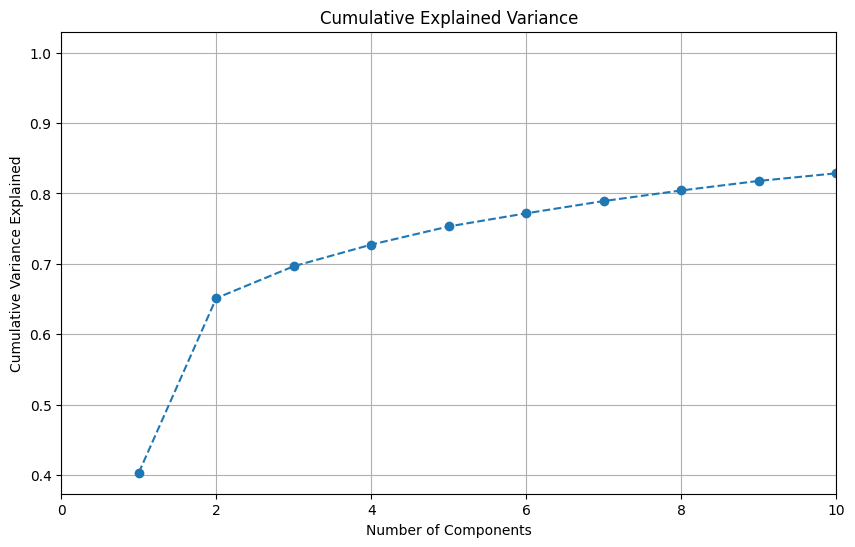

In [ ]:
# Extract country names
countries = education_df['Country Name']

# Drop non-numeric columns (like country names and codes)
data_numeric = education_df.drop(['Country Name', 'Country Code'], axis=1)

# Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_numeric)

# Perform PCA
pca = PCA()
pca.fit(data_scaled)

# Get the explained variance ratio
explained_variance_ratio = pca.explained_variance_ratio_

# Calculate cumulative explained variance
cumulative_variance = np.cumsum(explained_variance_ratio)

# Plot the cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance Explained')
plt.xlim(0, 10)  # Limiting x-axis to values from 0 to 10
plt.grid(True)
plt.show()


In [ ]:
# Perform PCA with 8 components
pca = PCA(n_components=8)
pca_data = pca.fit_transform(data_scaled)

# Create DataFrame for PCA results
pca_columns = [f"PC{i}" for i in range(1, 9)]  # PC1 to PC8 column names
pca_df = pd.DataFrame(pca_data, columns=pca_columns)

# Add 'Country Name' to the PCA DataFrame
pca_df['Country Name'] = countries.reset_index(drop=True)  # Resetting index to ensure alignment

# Make the Country Name column the first column
pca_df = pca_df[['Country Name'] + pca_columns]

# Rename country name as pca_name
pca_df.rename(columns={'Country Name': 'pca_name'}, inplace=True)

In [ ]:
# Now onto the clustering

